# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gensim


# 1. Loading the dataset

In [2]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

In [3]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


<li>Creating the target variable 'fake', with a value of 1 if an article is fake and 0 otherwise.
<li>Joining both dataframes to form the complete dataframe.</li>

In [5]:
fake_news['fake'] = 1
real_news['fake'] = 0
news = pd.concat([fake_news, real_news])
news.reset_index(inplace=True, drop=True)

In [6]:
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
counts = news['fake'].value_counts()
fake = counts[1]
real = counts[0]
print('The dataset consists of %d fake news articles and %d real news articles' % (fake,real))

The dataset consists of 23481 fake news articles and 21417 real news articles


# 2. Data Cleaning

### 2.1 Missing data

In [9]:
#Check for missing data
news.isna().value_counts()

title  text   subject  date   fake 
False  False  False    False  False    44898
dtype: int64

### 2.2 Duplicate articles

In [10]:
# Check for duplicates
news['all_text'] = news['title'] + ' '+ news['text'] 
num_dup = len(news) - len(news['all_text'].unique())
print('There are a total of %d duplicates in the dataset' % num_dup)

There are a total of 5793 duplicates in the dataset


In [11]:
news.drop_duplicates(subset=['all_text'], inplace = True)
news.shape

(39105, 6)

In [12]:
updated_counts = news['fake'].value_counts()
updated_fake = updated_counts[1]
updated_real = updated_counts[0]
print('After dropping duplicates, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After dropping duplicates, the dataset consists of 17908 fake news articles and 21197 real news articles


In [13]:
news['length'] = news['text'].map(lambda x: len(x.split()))
news = news[news['length'] != 0]
news.shape


(38658, 7)

In [14]:
updated_counts = news['fake'].value_counts()
updated_fake = updated_counts[1]
updated_real = updated_counts[0]
print('After dropping news with no text, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After dropping news with no text, the dataset consists of 17462 fake news articles and 21196 real news articles


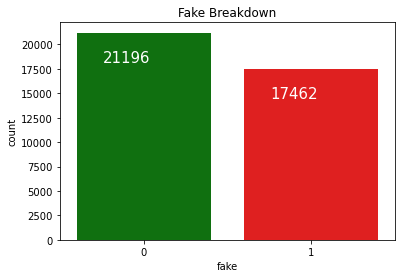

In [15]:
ax = sns.countplot(x='fake', data=news, palette=['g','r'])
ax.set_title('Fake Breakdown')
for i in ax.patches:
    ax.annotate(f'\n{i.get_height()}', (i.get_x() + 0.3, i.get_height()), ha='center', va='top', color='white', size=15)

### 2.3 Removing publisher information for real news
<li>With a quick scan of the real news articles in our dataset, we realise that most texts start off with publisher information, specifically Reuters <b>(eg. 'WASHINGTON (Reuters) -')</b>.</li>
<li>We want to be able to generalise our predictions models to articles from any publisher, hence we drop publisher information from our dataset.</li>

In [16]:
with_publisher_info = news['text'].str.contains('^.+ \(Reuters\) - ', regex=True).sum()
print('A total of %d out of %d real news articles contain publisher information' % (with_publisher_info,updated_real))

A total of 19557 out of 21196 real news articles contain publisher information


In [17]:
news['text'] = news['text'].map(lambda x: re.sub(r'^.+ \(Reuters\) - ','',x))
news[news['fake']== 0]['text']

23481    The head of a conservative Republican faction ...
23482    Transgender people will be allowed for the fir...
23483    The special counsel investigation of links bet...
23484    Trump campaign adviser George Papadopoulos tol...
23485    President Donald Trump called on the U.S. Post...
                               ...                        
44893    NATO allies on Tuesday welcomed President Dona...
44894    LexisNexis, a provider of legal, regulatory an...
44895    In the shadow of disused Soviet-era factories ...
44896    Vatican Secretary of State Cardinal Pietro Par...
44897    Indonesia will buy 11 Sukhoi fighter jets wort...
Name: text, Length: 21196, dtype: object

In [18]:
# update 'all_text' column
news['all_text'] = news['title'] + ' ' + news['text'] 

# 3. Exploratory Data Analysis

In [19]:
news.head()

,title,text,subject,date,fake,all_text,length
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,420


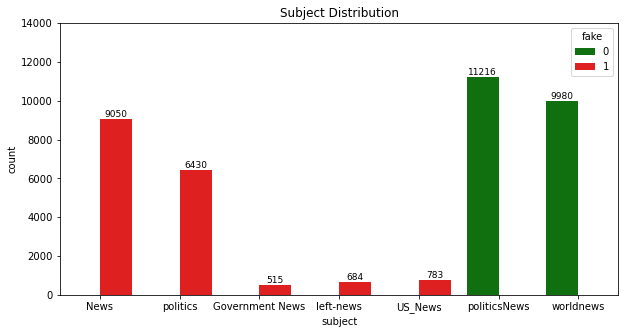

In [20]:
# Subject distribution
plt.figure(figsize=(10,5))
ax = sns.countplot(x='subject', data=news, hue='fake', palette=['g','r'])
ax.set_title('Subject Distribution')
ax.set(ylim=(0, 14000))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height().astype(int)}', (p.get_x()+0.2, p.get_height() + 1000), ha='center', va='top', color='black', size=9)


<Figure size 720x360 with 0 Axes>

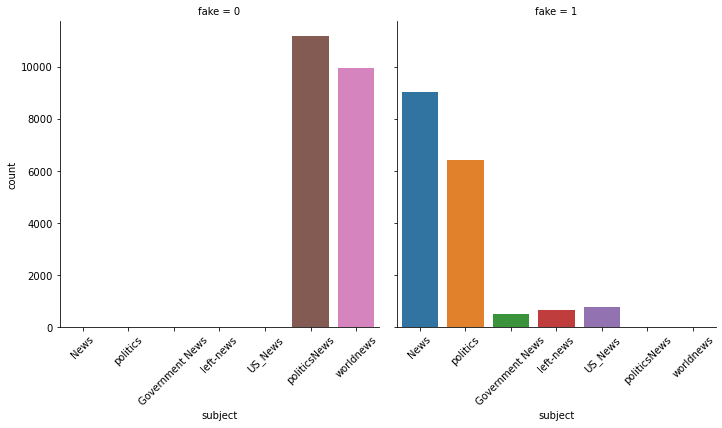

In [21]:
# Segmenting subject distribution by target

plt.figure(figsize=(10,5))
g = sns.catplot(x="subject", col="fake", data=news, kind="count")

#Rotating the xlabels
g.set_xticklabels(rotation=45)


It appears that all real news fall under either of the subjects 'politicsNews' or 'worldnews', while a significant proportion of fake news are categorised as 'News' or 'politics'.

<AxesSubplot:xlabel='length', ylabel='Count'>

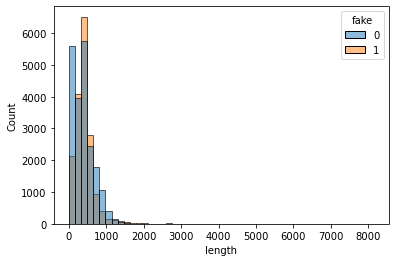

In [22]:
# Overall word length distribution
sns.histplot(x='length', data=news, bins = 50, hue='fake')

In [23]:
from wordcloud import WordCloud, STOPWORDS
#Word Cloud
stopwords = set(STOPWORDS)
def give_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=0
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

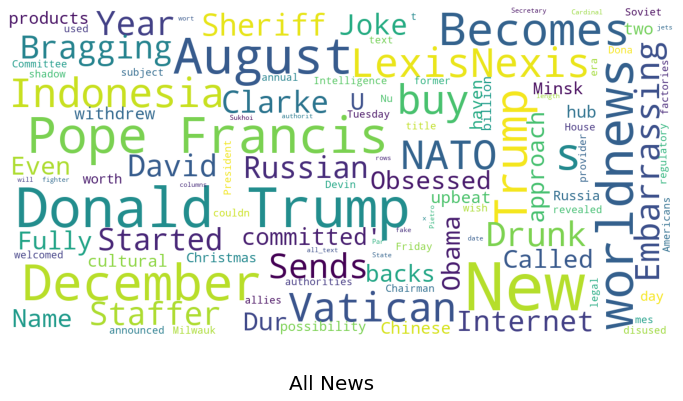

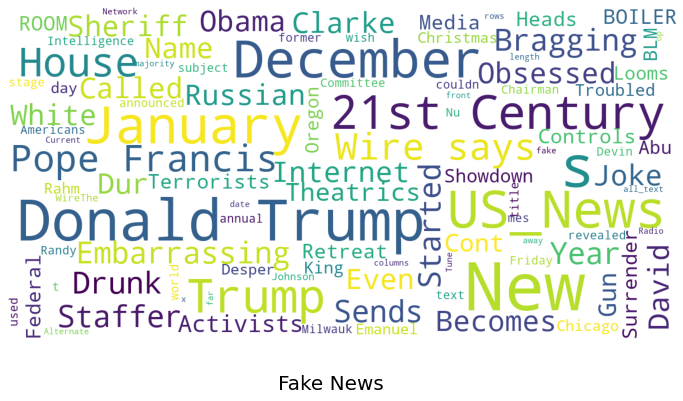

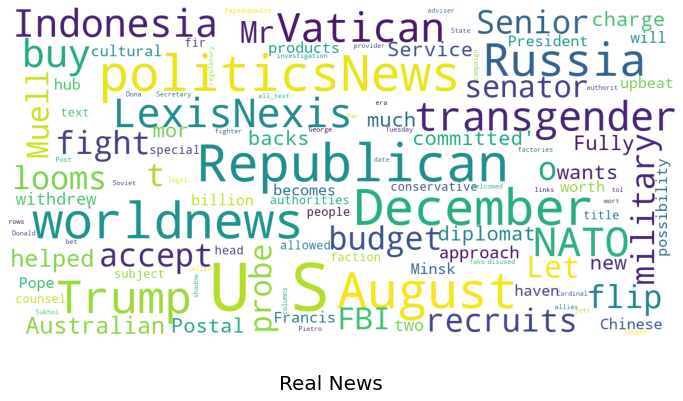

In [24]:
give_wordcloud(news,'All News')
give_wordcloud(news[news['fake'] == 1], 'Fake News')
give_wordcloud(news[news['fake'] == 0], 'Real News')

Fake news shows emotive and loaded language such as 'Drunk' and 'Obsessed', and biased persons such as Donald Trump are often mentioned.
Real news shows distinguished establishments such as 'NATO'and 'Reuters', and does not contain any emotive language. Instead, the words lean more towards factual.

# Data Preparation

In [25]:
news.head()

,title,text,subject,date,fake,all_text,length
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,420


In [26]:
news.shape

(38658, 7)

In [12]:
df = news.copy()
df.head()

,title,text,subject,date,fake,all_text,length,char_count,word_count,sent_count,...,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,495,2973,507,28,...,0,195,282,122,5.863905,18.107143,0.556213,0.384615,116,36
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,305,1968,313,11,...,0,120,209,39,6.287540,28.454545,0.667732,0.383387,94,10
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,580,3688,595,25,...,0,220,344,148,6.198319,23.800000,0.578151,0.369748,167,20
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,444,2853,458,15,...,0,164,278,120,6.229258,30.533333,0.606987,0.358079,143,24
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,420,2417,431,19,...,0,197,244,40,5.607889,22.684211,0.566125,0.457077,79,16


# Using All Text

In [39]:
X = df['all_text']
y = df['fake']

In [40]:
X.head()

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: all_text, dtype: object

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 1) #20% test

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 1) # 0.25 x 0.8 = 0.2, #20% valid


In [42]:
# Converting text to vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
X_train_vec = vectorization.fit_transform(X_train)
X_test_vec = vectorization.transform(X_test)

In [46]:
nlp_results = {}

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state=1)
GBC.fit(X_train_vec, y_train)

print(f'Accuracy of Train: {GBC.score(X_train_vec, y_train)}')
print(f'Accuracy of Test: {GBC.score(X_test_vec, y_test)}')
#results_title.loc['Boosted', 'train_acc'] = boost_clf.score(X_train, y_train)
#results_title.loc['Boosted', 'test_acc'] = boost_clf.score(X_test, y_test)

Accuracy of Train: 0.9833473452758197
Accuracy of Test: 0.9776254526642525


In [51]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_vec, y_train)
nlp_results['LR'] = [LR.score(X_train_vec, y_train), LR.score(X_test_vec, y_test)] 

In [54]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB().fit(X_train_vec, y_train)
nlp_results['NB']= [NB.score(X_train_vec, y_train), NB.score(X_test_vec, y_test)]

In [78]:
from sklearn.svm import SVC

SVM = SVC(kernel='rbf', gamma='scale', random_state=1)
SVM.fit(X_train_vec, y_train)
nlp_results['SVM']= [SVM.score(X_train_vec, y_train), SVM.score(X_test_vec, y_test)]

In [48]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=1)
RFC.fit(X_train_vec, y_train)

nlp_results['RFC']= [RFC.score(X_train_vec, y_train), RFC.score(X_test_vec, y_test)]
print(nlp_results)

{'RFC': [1.0, 0.9714174857734093]}


In [70]:
from xgboost import XGBClassifier
XGB = XGBClassifier(random_state=1)
XGB.fit(X_train_vec, y_train)
nlp_results['XGB'] = [XGB.score(X_train_vec, y_train), XGB.score(X_test_vec, y_test)]

In [7]:
print(nlp_results)

{'RFC': [1.0, 0.9714174857734093], 'XGB': [1.0, 0.987842731505432], 'LR': [0.9884563150746944, 0.9811174340403518], 'NB': [0.9457737825777662, 0.9372736678737713], 'SVM': [0.99899760719136, 0.987325400931195]}


In [8]:
nlp_results['NB'][0]

0.9457737825777662

In [10]:
import pandas as pd
tfidf_results_all_text = pd.DataFrame()

tfidf_results_all_text.loc['Logistic Regression', 'train_acc'] = nlp_results['LR'][0]
tfidf_results_all_text.loc['Logistic Regression', 'test_acc'] = nlp_results['LR'][1]

tfidf_results_all_text.loc['Multinomial Naive Bayes', 'train_acc'] = nlp_results['NB'][0]
tfidf_results_all_text.loc['Multinomial Naive Bayes', 'test_acc'] = nlp_results['NB'][1]

tfidf_results_all_text.loc['Support Vector Machine', 'train_acc'] = nlp_results['SVM'][0]
tfidf_results_all_text.loc['Support Vector Machine', 'test_acc'] = nlp_results['SVM'][1]

tfidf_results_all_text.loc['Random Forest', 'train_acc'] = nlp_results['RFC'][0]
tfidf_results_all_text.loc['Random Forest', 'test_acc'] = nlp_results['RFC'][1]

tfidf_results_all_text.loc['XGBoost', 'train_acc'] = nlp_results['XGB'][0]
tfidf_results_all_text.loc['XGBoost', 'test_acc'] = nlp_results['XGB'][1]
tfidf_results_all_text

,train_acc,test_acc
Logistic Regression,0.988456,0.981117
Multinomial Naive Bayes,0.945774,0.937274
Support Vector Machine,0.998998,0.987325
Random Forest,1.000000,0.971417
XGBoost,1.000000,0.987843


# Using only title

In [59]:
X2 = df['title']
y2 = df['fake']

In [60]:
X2.head()

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: title, dtype: object

In [61]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle = True, random_state = 1) #20% test

In [62]:
# Converting text to vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorization2 = TfidfVectorizer()
X_train_vec2 = vectorization2.fit_transform(X_train2)
X_test_vec2 = vectorization2.transform(X_test2)

In [63]:
nlp_results_title = {}

In [64]:
LR2 = LogisticRegression()
LR2.fit(X_train_vec2, y_train2)
nlp_results_title['LR'] = [LR2.score(X_train_vec2, y_train2), LR2.score(X_test_vec2, y_test2)] 

NB2 = MultinomialNB().fit(X_train_vec2, y_train2)
nlp_results_title['NB']= [NB2.score(X_train_vec2, y_train2), NB2.score(X_test_vec2, y_test2)]

In [69]:
RFC2 = RandomForestClassifier(random_state=1)
RFC2.fit(X_train_vec2, y_train2)
nlp_results_title['RFC']= [RFC2.score(X_train_vec2, y_train2), RFC2.score(X_test_vec2, y_test2)]

XGB2 = XGBClassifier(random_state=1)
XGB2.fit(X_train_vec2, y_train2)
nlp_results_title['XGB'] = [XGB2.score(X_train_vec2, y_train2), XGB2.score(X_test_vec2, y_test2)]

In [79]:
from sklearn.svm import SVC

SVM2 = SVC(kernel='rbf', gamma='scale', random_state=1)
SVM2.fit(X_train_vec2, y_train2)
nlp_results_title['SVM']= [SVM2.score(X_train_vec2, y_train2), SVM2.score(X_test_vec2, y_test2)]

In [81]:
print(nlp_results_title)

{'LR': [0.9650779279570588, 0.9443869632695292], 'NB': [0.957964172540904, 0.9408949818934299], 'RFC': [1.0, 0.9425763062596999], 'XGB': [0.9545366358403932, 0.9335230212105535], 'SVM': [0.9959904287654401, 0.9511122607346094]}


In [11]:
import pandas as pd
tfidf_results_title = pd.DataFrame()

tfidf_results_title.loc['Logistic Regression', 'train_acc'] = nlp_results_title['LR'][0]
tfidf_results_title.loc['Logistic Regression', 'test_acc'] = nlp_results_title['LR'][1]

tfidf_results_title.loc['Multinomial Naive Bayes', 'train_acc'] = nlp_results_title['NB'][0]
tfidf_results_title.loc['Multinomial Naive Bayes', 'test_acc'] = nlp_results_title['NB'][1]

tfidf_results_title.loc['Support Vector Machine', 'train_acc'] = nlp_results_title['SVM'][0]
tfidf_results_title.loc['Support Vector Machine', 'test_acc'] = nlp_results_title['SVM'][1]

tfidf_results_title.loc['Random Forest', 'train_acc'] = nlp_results_title['RFC'][0]
tfidf_results_title.loc['Random Forest', 'test_acc'] = nlp_results_title['RFC'][1]

tfidf_results_title.loc['XGBoost', 'train_acc'] = nlp_results_title['XGB'][0]
tfidf_results_title.loc['XGBoost', 'test_acc'] = nlp_results_title['XGB'][1]
tfidf_results_title

,train_acc,test_acc
Logistic Regression,0.965078,0.944387
Multinomial Naive Bayes,0.957964,0.940895
Support Vector Machine,0.995990,0.951112
Random Forest,1.000000,0.942576
XGBoost,0.954537,0.933523


In [82]:
pip install dill

     |████████████████████████████████| 110 kB 6.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [83]:
import dill
dill.dump_session('tfidf.db')

In [4]:
import dill
dill.load_session('tfidf.db')